In [ ]:
from google.colab import auth
from google.cloud import storage

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [ ]:
import collections
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
# Load SCIN Dataset

SCIN_GCP_PROJECT = 'dx-scin-public'
SCIN_GCS_BUCKET_NAME = 'dx-scin-public-data'
SCIN_GCS_CASES_CSV = 'dataset/scin_cases.csv'
SCIN_GCS_LABELS_CSV = 'dataset/scin_labels.csv'
SCIN_GCS_IMAGES_DIR = 'dataset/images/'


def initialize_df_with_metadata(bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

scin_bucket = storage.Client(SCIN_GCP_PROJECT).bucket(SCIN_GCS_BUCKET_NAME)

scin_no_label_df = initialize_df_with_metadata(scin_bucket, SCIN_GCS_CASES_CSV)
scin_df = augment_metadata_with_labels(scin_no_label_df, scin_bucket, SCIN_GCS_LABELS_CSV)
scin_df.set_index('case_id', inplace=True)
print(f'Loaded {len(scin_df)} rows.')

# scin_df is the main data frame we will be working with.
scin_df.head(5)

Loaded 5033 rows.


,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,race_ethnicity_hispanic_latino_or_spanish_origin,...,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
case_id,,,,,,,,,,,,,,,,,,,,,
-1000600354148496558,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,1.0
-1002039107727665188,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,3.0,3.0
-1003358831658393077,SCIN,1.0.0,2023,AGE_18_TO_29,MALE,NONE_IDENTIFIED,NaN,NaN,NaN,YES,...,YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,4.0
-1003826561155964328,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,4.0
-1003844406100696311,SCIN,1.0.0,2023,AGE_40_TO_49,FEMALE,FST3,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,1.0,1.0


In [ ]:
import cv2
import numpy as np

In [ ]:
def estimate_hydration(bucket, image_path):
    image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))  # PIL Image
    image = image.convert("RGB")  # Ensure it's in RGB format
    image_np = np.array(image)  # Convert PIL image to NumPy array
    image_cv = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (for OpenCV)
    image_hsv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2HSV)  # Convert to HSV
    brightness = np.mean(image_hsv[:, :, 2])  # Extract the V-channel (brightness)
    if brightness < 120:
        return "Dry"
    elif brightness > 220:
        return "Oily"
    else:
        return "Normal/Hydrated"

Dropdown(description='Case ID', options=('-1000600354148496558', '-1002039107727665188', '-1003358831658393077…

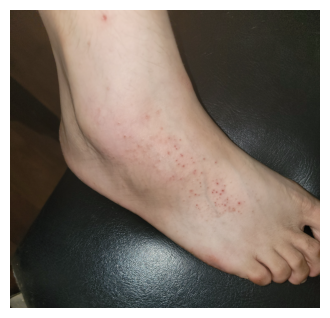

Skin Conditions ['Inflicted skin lesions', 'Eczema', 'Irritant Contact Dermatitis']
Confidence [4, 4, 3]
Hydration Analysis: ['Dry']


In [ ]:
import ipywidgets as widgets
from IPython.display import display
from google.colab import output as colab_output

def display_image(bucket, image_path):
  image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))
  f, axarr = plt.subplots(1, 1, figsize = (4, 4))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  plt.show()

def display_images_for_case(df, case_id):
  # Each volunteer contributor submitted up to 3 images
  image_paths = [df.loc[case_id, 'image_1_path'], df.loc[case_id, 'image_2_path'], df.loc[case_id, 'image_3_path']]
  hydration_scores = []
  for path in image_paths:
    if isinstance(path, str):
      scin_bucket = storage.Client(SCIN_GCP_PROJECT).bucket(SCIN_GCS_BUCKET_NAME)
      display_image(scin_bucket, path)
      hydration_type = estimate_hydration(scin_bucket, path)
      hydration_scores.append(hydration_type)

  conditions = df.loc[case_id, 'dermatologist_skin_condition_on_label_name']
  confidence = df.loc[case_id, 'dermatologist_skin_condition_confidence']
  print(f'Skin Conditions {conditions}')
  print(f'Confidence {confidence}')
  print(f"Hydration Analysis: {hydration_scores}")

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        colab_output.clear()
        display(case_id_dropdown)
        display_images_for_case(scin_df,case_id=change['new'])

case_id_dropdown = widgets.Dropdown(options=scin_df.index, description="Case ID")
display(case_id_dropdown)
case_id_dropdown.observe(on_change)
display_images_for_case(scin_df, case_id_dropdown.value)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

# Extract features (for now, using hydration as a simple feature)
scin_df['hydration_score'] = scin_df.apply(lambda row: estimate_hydration(scin_bucket, row['image_1_path']), axis=1)

# Convert categorical hydration scores to numerical values
hydration_mapping = {"Dry": 0, "Normal/Hydrated": 1, "Oily": 2}
scin_df['hydration_score'] = scin_df['hydration_score'].map(hydration_mapping)

# Define features and labels
X = scin_df[['hydration_score']]  # Add more features here
y = scin_df['dermatologist_skin_condition_on_label_name']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

NotFound: 404 GET https://storage.googleapis.com/download/storage/v1/b/dx-scin-public-data/o/dataset%2Fimages%2F-2243186711511406658.png?alt=media: No such object: dx-scin-public-data/dataset/images/-2243186711511406658.png: ('Request failed with status code', 404, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)